In [1]:
#import findspark
#findspark.init()
#import pyspark # only run after findspark.init()
#from pyspark.sql import SparkSession
#spark = SparkSession.builder.getOrCreate()
import pandas as pd
#sc = spark.sparkContext
import json 
from sodapy import Socrata
from keras import models
from keras import layers
import numpy as np 


In [33]:
import pipeline

In [31]:
url="data.buffalony.gov"
db="d6g9-xbgu"

In [36]:
df=pd.read_csv('data/wrangled.csv')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273439 entries, 0 to 273438
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            273439 non-null  int64  
 1   incident_datetime     273439 non-null  object 
 2   address_1             273439 non-null  object 
 3   city                  273439 non-null  object 
 4   state                 273439 non-null  object 
 5   latitude              273439 non-null  float64
 6   longitude             273439 non-null  float64
 7   hour_of_day           273439 non-null  int64  
 8   day_of_week           273439 non-null  object 
 9   parent_incident_type  273439 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 20.9+ MB


In [47]:
def data_cleaning1(df):
    df=df[['incident_datetime', 'latitude', 'longitude', 'day_of_week','parent_incident_type']]
    df.incident_datetime=pd.to_datetime(df.incident_datetime)
    df.latitude=df.latitude.astype(float)
    df.longitude=df.longitude.astype(float)
    df.day_of_week=df.day_of_week.str.replace('SATURDAY','Saturday')
    df.day_of_week=df.day_of_week.str.replace('FRIDAY','Friday')
    df.day_of_week=df.day_of_week.str.replace('SUNDAY', 'Sunday')
    df.day_of_week=df.day_of_week.str.replace('MONDAY','Monday')
    df.day_of_week=df.day_of_week.str.replace('TUESDAY','Tuesday')
    df.day_of_week=df.day_of_week.str.replace('WEDNESDAY','Wednesday')
    df.day_of_week=df.day_of_week.str.replace('THURSDAY','Thursday')
    return df 

In [48]:
cleaned1=data_cleaning1(df)

In [49]:
cleaned1.columns

Index(['incident_datetime', 'latitude', 'longitude', 'day_of_week',
       'parent_incident_type'],
      dtype='object')

In [50]:
cleaned=cleaned1
cleaned=cleaned.sort_values('incident_datetime')
cleaned=cleaned.set_index('incident_datetime')
cleaned=cleaned.loc["01-01-2010":]
cleaned.head()
cleaned=cleaned.reset_index()

In [54]:
cleaned['log']=1

In [55]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196062 entries, 0 to 196061
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   incident_datetime     196062 non-null  datetime64[ns]
 1   latitude              196062 non-null  float64       
 2   longitude             196062 non-null  float64       
 3   day_of_week           196062 non-null  object        
 4   parent_incident_type  196062 non-null  object        
 5   log                   196062 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 9.0+ MB


In [56]:
train,test=sliced_advanced(cleaned,'01-01-2021','01-02-2021')

In [57]:
train

,latitude,longitude,day_of_week,parent_incident_type,log
incident_datetime,,,,,
2010-01-01 00:00:00,42.874699,-78.823627,Friday,Theft,1
2010-01-01 00:00:00,42.927216,-78.848810,Friday,Other Sexual Offense,1
2010-01-01 00:00:00,42.941782,-78.883643,Friday,Theft of Vehicle,1
2010-01-01 00:00:00,42.935244,-78.829687,Friday,Other Sexual Offense,1
2010-01-01 00:00:00,42.839594,-78.801492,Friday,Theft,1
...,...,...,...,...,...
2021-01-01 21:46:30,42.937000,-78.851000,Friday,Theft of Vehicle,1
2021-01-01 22:00:00,42.919000,-78.856000,Saturday,Theft of Vehicle,1
2021-01-01 22:00:00,42.883000,-78.866000,Sunday,Assault,1


In [58]:
date=cleaned[['incident_datetime','log']]
date=date.set_index('incident_datetime')

In [60]:
date_resampled=date.resample('5 min').sum()

In [61]:
date_resampled

,log
incident_datetime,
2010-01-01 00:00:00,24
2010-01-01 00:05:00,1
2010-01-01 00:10:00,1
2010-01-01 00:15:00,0
2010-01-01 00:20:00,0
...,...
2021-08-31 02:15:00,0
2021-08-31 02:20:00,0
2021-08-31 02:25:00,0


<AxesSubplot:xlabel='incident_datetime'>

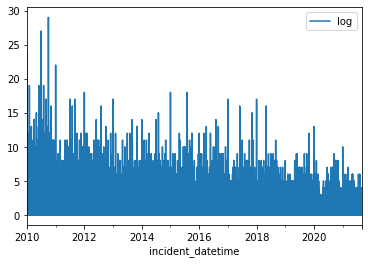

In [62]:
date_resampled.plot(kind='line')

 # dataframe ready for modeling , functions were made to promptly import all types of data , cleaned and ready to go. 


In [63]:
#creating a test split function
def train_test(df,train_end_date,test_start_date):
    train=df.loc[:train_end_date]
    test=df.loc[test_start_date:]
    return train,test
date_train,date_test=train_test(date_resampled,'01-01-2021','01-02-2021')

# Time series 

In [64]:
date_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1157472 entries, 2010-01-01 00:00:00 to 2021-01-01 23:55:00
Freq: 5T
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   log     1157472 non-null  int64
dtypes: int64(1)
memory usage: 17.7 MB


In [72]:
date_test

,log
incident_datetime,
2021-01-02 00:10:00,1
2021-01-02 00:10:00,1
2021-01-02 01:00:00,1
2021-01-02 01:29:26,1
2021-01-02 05:44:30,1
...,...
2021-08-30 19:10:35,1
2021-08-30 19:30:00,1
2021-08-30 21:15:00,1


In [74]:
date_train,date_test=train_test(date,'01-01-2021','01-02-2021')

In [69]:
date_train=date_train.reset_index()
X=date_train.incident_datetime
Y=date_train.log

In [321]:
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

date data is ready for predictive modeling 

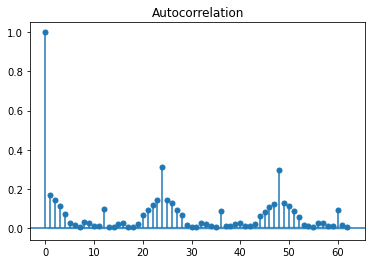

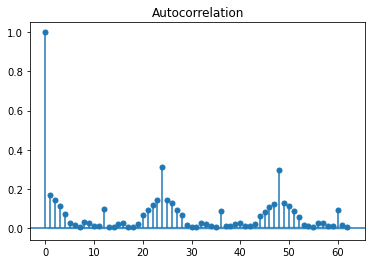

In [75]:
plot_acf(date_train.resample('1h').sum(),lags=62)

In [76]:
train_data=date_train.resample('15 min').sum()


In [82]:
train_data.shape

(385823, 1)

In [144]:
model=SARIMAX(date_train,order=(0,1,0),seasonal_order=(0,0,0,24))
res1=model.fit()


C:\Users\mmioi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\mmioi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [148]:
pred=res1.predict(start='12-25-2020',end='01-01-2021')

In [153]:
pred.resample('1h').sum()

incident_datetime
2020-12-25 00:00:00    5.0
2020-12-25 01:00:00    0.0
2020-12-25 02:00:00    2.0
2020-12-25 03:00:00    0.0
2020-12-25 04:00:00    0.0
                      ... 
2020-12-31 20:00:00    4.0
2020-12-31 21:00:00    2.0
2020-12-31 22:00:00    2.0
2020-12-31 23:00:00    3.0
2021-01-01 00:00:00    1.0
Freq: H, Name: predicted_mean, Length: 169, dtype: float64

In [91]:
test=date_train.loc['12-25-2020':]
predsdf=pd.DataFrame(pred)

<ipython-input-94-85a52a944192>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax22=fig.add_subplot(111)


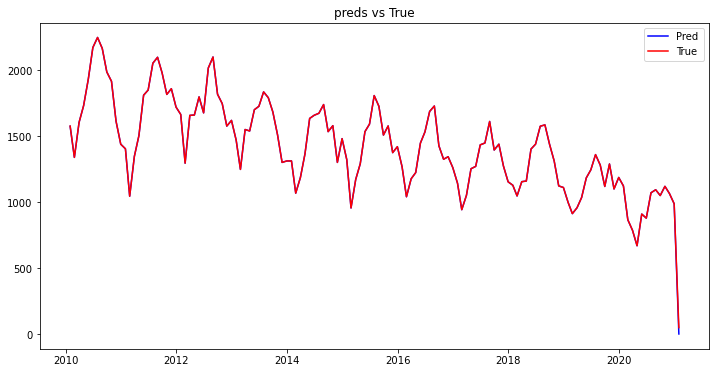

In [94]:
fig = plt.figure(figsize=(12, 6))
ax1=fig.add_subplot(111)
ax22=fig.add_subplot(111)

ax1.plot(predsdf.resample('1m').sum(),color='blue',label='Pred')
ax1.set_title('preds vs True')
ax22.plot(date_train.resample('1m').sum(),color='red',label='True ')
plt.legend()


In [ ]:
exog=date_test.reset_index().incident_datetime

In [ ]:
exog.set_index(0)

# classification

In [ ]:
dummies=pd.get_dummies(cleaned.day_of_week)

In [169]:
pre_processed=pd.merge(cleaned,dummies,left_index=True,right_index=True)

In [170]:
pre_processed=pre_processed.drop('day_of_week',axis=1)

In [171]:
pre_processed=pre_processed.set_index('incident_datetime')

In [180]:
from sklearn.model_selection import train_test_split
X=pre_processed.drop('parent_incident_type',axis=1)
Y=pre_processed.parent_incident_type.values

In [181]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=123)

In [320]:
from sklearn.ensemble import RandomForestClassifier as rf


In [141]:
n_e = [200,400, 600, 1000, 2000]

for n in n_e:
    from sklearn.ensemble import RandomForestClassifier as rf
    rf = rf(n_estimators=n, max_depth = 5, random_state = 0,n_features=20,bootstrap=False,criterion='entropy')
    rf.fit(X_train, y_train)
    print("Learning rate: ", n)
    print("Accuracy score (training): {0:.3f}".format(rf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(rf.score(X_test, y_test)))
    print()

Learning rate:  200
Accuracy score (training): 0.445
Accuracy score (validation): 0.443

Learning rate:  400
Accuracy score (training): 0.445
Accuracy score (validation): 0.443

Learning rate:  600
Accuracy score (training): 0.445
Accuracy score (validation): 0.443

Learning rate:  1000
Accuracy score (training): 0.445
Accuracy score (validation): 0.443

Learning rate:  2000
Accuracy score (training): 0.445
Accuracy score (validation): 0.443



In [319]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


In [139]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=200, learning_rate = learning_rate, max_features=5, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.447
Accuracy score (validation): 0.445

Learning rate:  0.1
Accuracy score (training): 0.448
Accuracy score (validation): 0.446

Learning rate:  0.25
Accuracy score (training): 0.450
Accuracy score (validation): 0.447

Learning rate:  0.5
Accuracy score (training): 0.193
Accuracy score (validation): 0.195

Learning rate:  0.75
Accuracy score (training): 0.135
Accuracy score (validation): 0.134



KeyboardInterrupt: 

both gb and fr failed spectacularly. reducing the amount of categories 
/ three different catregories [Sexual , Violent,Property]

In [166]:
pre_processed.parent_incident_type.unique()

array(['Theft', 'Other Sexual Offense', 'Breaking & Entering',
       'Sexual Assault', 'Theft of Vehicle', 'Assault', 'Robbery',
       'Homicide', 'Sexual Offense'], dtype=object)

In [172]:
pre_processed.parent_incident_type=pre_processed.parent_incident_type.str.replace('Breaking & Entering','Property')
pre_processed.parent_incident_type=pre_processed.parent_incident_type.str.replace('Theft of Vehicle','Property')
pre_processed.parent_incident_type=pre_processed.parent_incident_type.str.replace('Theft','Property')

In [173]:
pre_processed.parent_incident_type.unique()

array(['Property', 'Other Sexual Offense', 'Sexual Assault', 'Assault',
       'Robbery', 'Homicide', 'Sexual Offense'], dtype=object)

In [176]:
pre_processed.parent_incident_type=pre_processed.parent_incident_type.str.replace('Robbery','Violent')
pre_processed.parent_incident_type=pre_processed.parent_incident_type.str.replace( 'Assault','Violent')
pre_processed.parent_incident_type=pre_processed.parent_incident_type.str.replace('Homicide','Violent')

In [174]:
pre_processed.parent_incident_type=pre_processed.parent_incident_type.str.replace('Sexual Assault','Sexual')
pre_processed.parent_incident_type=pre_processed.parent_incident_type.str.replace('Sexual Offense','Sexual')
pre_processed.parent_incident_type=pre_processed.parent_incident_type.str.replace('Other Sexual Offense','Sexual')

In [177]:
pre_processed.parent_incident_type.unique()
    

array(['Property', 'Other Sexual', 'Sexual', 'Violent'], dtype=object)

In [178]:
pre_processed.parent_incident_type=pre_processed.parent_incident_type.str.replace('Other Sexual','Sexual')

In [179]:
pre_processed.parent_incident_type.unique()

array(['Property', 'Sexual', 'Violent'], dtype=object)

In [183]:
n_e = [20,40, 60, 100, 200]

for n in n_e:
    from sklearn.ensemble import RandomForestClassifier as rf
    rf = rf(n_estimators=100, max_depth = 5, random_state = 0,bootstrap=False,criterion='entropy')
    rf.fit(X_train, y_train)
    print("Learning rate: ", n)
    print("Accuracy score (training): {0:.3f}".format(rf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(rf.score(X_test, y_test)))
    print()

Learning rate:  20
Accuracy score (training): 0.706
Accuracy score (validation): 0.706

Learning rate:  40
Accuracy score (training): 0.706
Accuracy score (validation): 0.706

Learning rate:  60
Accuracy score (training): 0.706
Accuracy score (validation): 0.706

Learning rate:  100
Accuracy score (training): 0.706
Accuracy score (validation): 0.706

Learning rate:  200
Accuracy score (training): 0.706
Accuracy score (validation): 0.706



In [187]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate = learning_rate, max_features=5, max_depth = 4, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.707
Accuracy score (validation): 0.707

Learning rate:  0.1
Accuracy score (training): 0.708
Accuracy score (validation): 0.707

Learning rate:  0.25
Accuracy score (training): 0.711
Accuracy score (validation): 0.708

Learning rate:  0.5
Accuracy score (training): 0.715
Accuracy score (validation): 0.708

Learning rate:  0.75
Accuracy score (training): 0.718
Accuracy score (validation): 0.705

Learning rate:  1
Accuracy score (training): 0.716
Accuracy score (validation): 0.704



In [190]:
rating_probs = pre_processed.dropna().groupby('parent_incident_type').size().div(len(df))
rating_probs 

parent_incident_type
Property    0.506343
Sexual      0.012602
Violent     0.198077
dtype: float64

In [195]:
holidays=pd.read_csv(r'C:\Users\mmioi\Downloads\US Holiday Dates (2004-2021).csv')

In [197]:
holidays.head()


,Date,Holiday,WeekDay,Month,Day,Year
0,2004-07-04,4th of July,Sunday,7,4,2004
1,2005-07-04,4th of July,Monday,7,4,2005
2,2006-07-04,4th of July,Tuesday,7,4,2006
3,2007-07-04,4th of July,Wednesday,7,4,2007
4,2008-07-04,4th of July,Friday,7,4,2008


In [202]:
holidays=holidays[['Date','Holiday']]
holidays.Date=pd.to_datetime(holidays.Date)

In [206]:
holidays=holidays.set_index('Date')
holidays.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 342 entries, 2004-07-04 to 2011-04-24
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Holiday  342 non-null    object
dtypes: object(1)
memory usage: 5.3+ KB


In [220]:
holidays=pd.get_dummies(holidays)

In [228]:
holidays=holidays.dropna()

In [292]:
pre_processed1=pre_processed.join(holidays,how='left')

In [295]:
pre_processed1=pre_processed1.replace(np.nan,0.0)

In [296]:
pre_processed1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 196080 entries, 2010-01-01 00:00:00 to 2021-08-31 02:35:24
Data columns (total 29 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   latitude                             196080 non-null  float64
 1   longitude                            196080 non-null  float64
 2   parent_incident_type                 196080 non-null  object 
 3   log                                  196080 non-null  int64  
 4   Friday                               196080 non-null  uint8  
 5   Monday                               196080 non-null  uint8  
 6   Saturday                             196080 non-null  uint8  
 7   Sunday                               196080 non-null  uint8  
 8   Thursday                             196080 non-null  uint8  
 9   Tuesday                              196080 non-null  uint8  
 10  Wednesday                            196080 no

In [297]:
X=pre_processed1.drop('parent_incident_type',axis=1)
Y=pre_processed1.parent_incident_type.values

In [298]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=123)

In [299]:
md = [2,3,4,5,7,]

for n in md:
    from sklearn.ensemble import RandomForestClassifier as rf
    rf = rf(n_estimators=200, max_depth = 2,max_leaf_nodes=n, random_state = 123,bootstrap=True,criterion='gini')
    rf.fit(X_train, y_train)
    print("Learning rate: ", n)
    print("Accuracy score (training): {0:.3f}".format(rf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(rf.score(X_test, y_test)))
    print()

Learning rate:  2
Accuracy score (training): 0.705
Accuracy score (validation): 0.709

Learning rate:  3
Accuracy score (training): 0.705
Accuracy score (validation): 0.709

Learning rate:  4
Accuracy score (training): 0.705
Accuracy score (validation): 0.709

Learning rate:  5
Accuracy score (training): 0.705
Accuracy score (validation): 0.709

Learning rate:  7
Accuracy score (training): 0.705
Accuracy score (validation): 0.709



In [300]:
learning_rates = [0.01,0.02,0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=500, learning_rate = learning_rate, max_features=4, max_depth = 3, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.01
Accuracy score (training): 0.705
Accuracy score (validation): 0.709

Learning rate:  0.02
Accuracy score (training): 0.705
Accuracy score (validation): 0.709



KeyboardInterrupt: 

In [301]:
from sklearn.ensemble import RandomForestClassifier as rf
rf = rf(n_estimators=200, max_depth = 2,random_state = 123,bootstrap=True,criterion='gini')
rf.fit(X_train, y_train)
print("Learning rate: ", n)
print("Accuracy score (training): {0:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(rf.score(X_test, y_test)))
print()

Learning rate:  7
Accuracy score (training): 0.705
Accuracy score (validation): 0.709



In [302]:
ypred=rf.predict(X_test)

In [303]:
confusion_matrix(y_test,ypred)

array([[27820,     0,     0],
       [  689,     0,     0],
       [10707,     0,     0]], dtype=int64)

In [304]:
print(classification_report(y_test,ypred))


C:\Users\mmioi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    Property       0.71      1.00      0.83     27820
      Sexual       0.00      0.00      0.00       689
     Violent       0.00      0.00      0.00     10707

    accuracy                           0.71     39216
   macro avg       0.24      0.33      0.28     39216
weighted avg       0.50      0.71      0.59     39216



C:\Users\mmioi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mmioi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [305]:
pre_processed1.columns

Index(['latitude', 'longitude', 'parent_incident_type', 'log', 'Friday',
       'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'Holiday_4th of July', 'Holiday_Christmas Day', 'Holiday_Christmas Eve',
       'Holiday_Columbus Day', 'Holiday_Eastern Easter', 'Holiday_Juneteenth',
       'Holiday_Labor Day', 'Holiday_Labor Day Weekend',
       'Holiday_Martin Luther King, Jr. Day', 'Holiday_Memorial Day',
       'Holiday_New Year's Day', 'Holiday_New Year’s Eve',
       'Holiday_Thanksgiving Day', 'Holiday_Thanksgiving Eve',
       'Holiday_Valentine’s Day', 'Holiday_Veterans Day',
       'Holiday_Washington's Birthday', 'Holiday_Western Easter'],
      dtype='object')

In [306]:
pre_processed1.parent_incident_type.value_counts()

Property    138467
Violent      54166
Sexual        3447
Name: parent_incident_type, dtype: int64

# Balancing the DataSet 

In [307]:
# Class count
count_class_0, count_class_1 ,count_class_2= pre_processed1.parent_incident_type.value_counts()

# Divide by class
df_class_0 = pre_processed1[pre_processed1['parent_incident_type'] == 'Property']
df_class_1 = pre_processed1[pre_processed1['parent_incident_type'] == 'Violent']
df_class_2 = pre_processed1[pre_processed1['parent_incident_type'] == 'Sexual']

In [328]:
# Undersample 0-class and concat the DataFrames of both class
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1,df_class_2], axis=0)

print('Random under-sampling:')
print(df_test_under.parent_incident_type.value_counts())

Random under-sampling:
Violent     54166
Property    54166
Sexual       3447
Name: parent_incident_type, dtype: int64


In [312]:
X=df_test_under.drop('parent_incident_type',axis=1)
Y=df_test_under.parent_incident_type.values

In [318]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=15)

In [319]:
md = [2,3,4,5,7,]

for n in md:
    from sklearn.ensemble import RandomForestClassifier as rf
    rf = rf(n_estimators=200, max_depth = 2,max_leaf_nodes=n, random_state = 123,bootstrap=True,criterion='gini')
    rf.fit(X_train, y_train)
    print("Learning rate: ", n)
    print("Accuracy score (training): {0:.3f}".format(rf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(rf.score(X_test, y_test)))
    print()

Learning rate:  2
Accuracy score (training): 0.545
Accuracy score (validation): 0.542

Learning rate:  3
Accuracy score (training): 0.545
Accuracy score (validation): 0.543

Learning rate:  4
Accuracy score (training): 0.547
Accuracy score (validation): 0.545

Learning rate:  5
Accuracy score (training): 0.547
Accuracy score (validation): 0.545

Learning rate:  7
Accuracy score (training): 0.547
Accuracy score (validation): 0.545



In [317]:
import tensorflow as tf
from tensorflow import keras

In [278]:
len(X_train.columns)

28

In [329]:
df_test_under.parent_incident_type=df_test_under.parent_incident_type.astype('str')

In [333]:
df_test1=pd.DataFrame(df_test_under)
df_test_under=df_test1

In [337]:
df_test_under.parent_incident_type=df_test_under.parent_incident_type.replace('Violent',1)
df_test_under.parent_incident_type=df_test_under.parent_incident_type.replace('Property',0)
df_test_under.parent_incident_type=df_test_under.parent_incident_type.replace('Sexual',2)


In [338]:
df_test_under.parent_incident_type.unique()

array([0, 1, 2], dtype=int64)

In [339]:
X=df_test_under.drop('parent_incident_type',axis=1).values
Y=df_test_under.parent_incident_type.values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=15)

In [324]:
def ANN(X_train, y_train, X_test, y_test, loss, weights):
    model = keras.Sequential([
        keras.layers.Dense(28, input_dim=28, activation='relu'),
        keras.layers.Dense(52, activation='relu'),
        keras.layers.Dense(28, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    
    if weights == -1:
        model.fit(X_train, y_train, epochs=50)
    else:
        model.fit(X_train, y_train, epochs=50, class_weight = weights)
    
    print(model.evaluate(X_test, y_test))
    
    y_preds = model.predict(X_test)
    y_preds = np.round(y_preds)
    
    print("Classification Report: \n", classification_report(y_test, y_preds))
    
    return y_preds

In [341]:
ANN(X_train, y_train, X_test, y_test,"categorical_crossentropy", -1)

Epoch 1/100
2795/2795 [==============================] - 1s 469us/step - loss: 6.5068e-08 - accuracy: 0.4848
Epoch 2/100
2795/2795 [==============================] - 1s 452us/step - loss: 6.5068e-08 - accuracy: 0.4848
Epoch 3/100
2795/2795 [==============================] - 1s 453us/step - loss: 6.5068e-08 - accuracy: 0.4848
Epoch 4/100
2795/2795 [==============================] - 1s 463us/step - loss: 6.5068e-08 - accuracy: 0.4848
Epoch 5/100
2795/2795 [==============================] - 1s 454us/step - loss: 6.5068e-08 - accuracy: 0.4848
Epoch 6/100
2795/2795 [==============================] - 1s 456us/step - loss: 6.5068e-08 - accuracy: 0.4848
Epoch 7/100
2795/2795 [==============================] - 1s 453us/step - loss: 6.5068e-08 - accuracy: 0.4848
Epoch 8/100
2795/2795 [==============================] - 1s 459us/step - loss: 6.5068e-08 - accuracy: 0.4848
Epoch 9/100
2795/2795 [==============================] - 1s 454us/step - loss: 6.5068e-08 - accuracy: 0.4848
Epoch 10/100
2795/2

2795/2795 [==============================] - 1s 457us/step - loss: 6.5068e-08 - accuracy: 0.4848
Epoch 76/100
2795/2795 [==============================] - 1s 463us/step - loss: 6.5068e-08 - accuracy: 0.4848
Epoch 77/100
2795/2795 [==============================] - 1s 460us/step - loss: 6.5068e-08 - accuracy: 0.4848
Epoch 78/100
2795/2795 [==============================] - 1s 475us/step - loss: 6.5068e-08 - accuracy: 0.4848
Epoch 79/100
2795/2795 [==============================] - 1s 461us/step - loss: 6.5068e-08 - accuracy: 0.4848
Epoch 80/100
2795/2795 [==============================] - 1s 467us/step - loss: 6.5068e-08 - accuracy: 0.4848
Epoch 81/100
2795/2795 [==============================] - 1s 463us/step - loss: 6.5068e-08 - accuracy: 0.4848
Epoch 82/100
2795/2795 [==============================] - 1s 471us/step - loss: 6.5068e-08 - accuracy: 0.4848
Epoch 83/100
2795/2795 [==============================] - 1s 464us/step - loss: 6.5068e-08 - accuracy: 0.4848
Epoch 84/100
2795/2795 

C:\Users\mmioi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mmioi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mmioi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [342]:
pre_processed2=pre_processed1
pre_processed2.parent_incident_type=pre_processed2.parent_incident_type.replace('Violent',1)
pre_processed2.parent_incident_type=pre_processed2.parent_incident_type.replace('Property',0)
pre_processed2.parent_incident_type=pre_processed2.parent_incident_type.replace('Sexual',2)


In [346]:
X=pre_processed2.drop('parent_incident_type',axis=1).values
Y=pre_processed2.parent_incident_type.values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [356]:
ANN(X_train, y_train, X_test, y_test,"squared_hinge", -2)

Epoch 1/50
4902/4902 [==============================] - 2s 457us/step - loss: 1.0002 - accuracy: 0.7072
Epoch 2/50
4902/4902 [==============================] - 2s 447us/step - loss: 1.0000 - accuracy: 0.7072
Epoch 3/50
4902/4902 [==============================] - 2s 450us/step - loss: 1.0000 - accuracy: 0.7072
Epoch 4/50
4902/4902 [==============================] - 2s 451us/step - loss: 1.0000 - accuracy: 0.7072
Epoch 5/50
4902/4902 [==============================] - 2s 447us/step - loss: 1.0000 - accuracy: 0.7072
Epoch 6/50
4902/4902 [==============================] - 2s 449us/step - loss: 1.0000 - accuracy: 0.7072
Epoch 7/50
4902/4902 [==============================] - 2s 449us/step - loss: 1.0000 - accuracy: 0.7072
Epoch 8/50
4902/4902 [==============================] - 2s 463us/step - loss: 1.0000 - accuracy: 0.7072
Epoch 9/50
4902/4902 [==============================] - 2s 473us/step - loss: 1.0000 - accuracy: 0.7072
Epoch 10/50
4902/4902 [==============================] - 2s 462u

C:\Users\mmioi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mmioi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mmioi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [366]:
pip install urllib


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement urllib
ERROR: No matching distribution found for urllib


In [365]:
pip install bs4

  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=1c13df6730db89bae9639e6061b6160198defe6296a24a53b4f1820925816707
  Stored in directory: c:\users\mmioi\appdata\local\pip\cache\wheels\75\78\21\68b124549c9bdc94f822c02fb9aa3578a669843f9767776bca
Successfully built bs4
Note: you may need to restart the kernel to use updated packages.


# adding Buffalo's event Calendar as a new feature 

In [2]:
import bs4 
from urllib.request import urlopen as ureq
from bs4 import BeautifulSoup as soup

In [36]:
url=r'C:\Users\mmioi\Downloads\calendar.txt'

In [50]:
page_soup=soup(url,'html.parser')

In [51]:
page_soup.body

In [210]:
hello=pd.read_csv(r'C:\Users\mmioi\Downloads\Calendar cleaned.csv',header=None,index_col=None,parse_dates=True,infer_datetime_format=True)

In [211]:
hello.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

In [212]:
hello

,0,1,2,3,4,5,6,7,8,9
0,February,10,2018,10:00,AM,-,12:30,PM,NaN,NaN
1,February,10,2018,10:30,AM,-,12:15,PM,NaN,NaN
2,February,10,2018,12:00,PM,-,4:00,PM,NaN,NaN
3,March,3,2018,12:00,PM,-,3:00,PM,NaN,NaN
4,March,17,2018,12:00,PM,-,2:00,PM,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1123,November,13,2021,8:00,AM,-,1:00,PM,NaN,NaN
1124,November,20,2021,8:00,AM,-,1:00,PM,NaN,NaN
1125,November,25,2021,9:00,AM,-,12:00,PM,NaN,NaN
1126,November,27,2021,8:00,AM,-,1:00,PM,NaN,NaN


In [213]:
hello=hello.rename(columns={0:'Month',1:'Day',2:'Year',3:'hour',4:'period'})

In [214]:
hello=hello[['Year','Month','Day']]

In [215]:
hello.Month.unique()

array(['February', 'March', 'April', 'May', 'June', 'July', '\x0c',
       'August', 'September', 'October', 'November', 'December',
       'January', 'from', nan, '1pm-6pm'], dtype=object)

In [216]:
hello.Month=hello.Month.replace('February',2)
hello.Month=hello.Month.replace('March',3)
hello.Month=hello.Month.replace('April',4)
hello.Month=hello.Month.replace('May',5)
hello.Month=hello.Month.replace('June',6)
hello.Month=hello.Month.replace('July',7)
hello.Month=hello.Month.replace('August',8)
hello.Month=hello.Month.replace('September',9)
hello.Month=hello.Month.replace('October',10)
hello.Month=hello.Month.replace('November',11)
hello.Month=hello.Month.replace('December',12)
hello.Month=hello.Month.replace('January',1)

In [239]:
df3=pd.to_datetime(hello,yearfirst=True,errors='coerce',format='%D-%m-%Y-%h')

In [240]:
df3.head()

0   2018-02-10
1   2018-02-10
2   2018-02-10
3   2018-03-03
4   2018-03-17
dtype: datetime64[ns]

In [241]:
df3=df3.dropna()

In [242]:
df2=pd.DataFrame(df3)

In [246]:
df2=df2.rename(columns={0:'Date'})
df2=df2.set_index("Date")


KeyError: "None of ['Date'] are in the columns"

In [251]:
df3=df2.resample('1min').sum()

### 

In [253]:
df2['event']=1

In [254]:
df3['event']=1

In [264]:
df3=df3.reset_index()


,Date,event
0,2018-02-10 00:00:00,1
1,2018-02-10 00:01:00,1
2,2018-02-10 00:02:00,1
3,2018-02-10 00:03:00,1
4,2018-02-10 00:04:00,1
...,...,...
2005916,2021-12-03 23:56:00,1
2005917,2021-12-03 23:57:00,1
2005918,2021-12-03 23:58:00,1
2005919,2021-12-03 23:59:00,1


In [271]:
df3=pd.DataFrame(df3)


In [275]:
df3=df3.reset_index()

In [283]:
df3.Date

0         2018-02-10 00:00:00
1         2018-02-10 00:01:00
2         2018-02-10 00:02:00
3         2018-02-10 00:03:00
4         2018-02-10 00:04:00
                  ...        
2005916   2021-12-03 23:56:00
2005917   2021-12-03 23:57:00
2005918   2021-12-03 23:58:00
2005919   2021-12-03 23:59:00
2005920   2021-12-04 00:00:00
Name: Date, Length: 2005921, dtype: datetime64[ns]

In [354]:
df4=pd.read_csv('data\pre_processed.csv')
df4.columns

Index(['Unnamed: 0', 'latitude', 'longitude', 'parent_incident_type', 'log',
       'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday', 'Holiday_4th of July', 'Holiday_Christmas Day',
       'Holiday_Christmas Eve', 'Holiday_Columbus Day',
       'Holiday_Eastern Easter', 'Holiday_Juneteenth', 'Holiday_Labor Day',
       'Holiday_Labor Day Weekend', 'Holiday_Martin Luther King, Jr. Day',
       'Holiday_Memorial Day', 'Holiday_New Year's Day',
       'Holiday_New Year’s Eve', 'Holiday_Thanksgiving Day',
       'Holiday_Thanksgiving Eve', 'Holiday_Valentine’s Day',
       'Holiday_Veterans Day', 'Holiday_Washington's Birthday',
       'Holiday_Western Easter'],
      dtype='object')

In [355]:
df4=df4.rename(columns={'Unnamed: 0':'Date'})
df4.Date=pd.to_datetime(df4.Date)

In [356]:
df4

,Date,latitude,longitude,parent_incident_type,log,Friday,Monday,Saturday,Sunday,Thursday,...,"Holiday_Martin Luther King, Jr. Day",Holiday_Memorial Day,Holiday_New Year's Day,Holiday_New Year’s Eve,Holiday_Thanksgiving Day,Holiday_Thanksgiving Eve,Holiday_Valentine’s Day,Holiday_Veterans Day,Holiday_Washington's Birthday,Holiday_Western Easter
0,2010-01-01 00:00:00,42.874699,-78.823627,0,1,1,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-01 00:00:00,42.958426,-78.855482,0,1,1,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-01-01 00:00:00,42.948746,-78.841021,2,1,1,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-01-01 00:00:00,42.869867,-78.849571,0,1,1,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-01-01 00:00:00,42.921298,-78.891109,2,1,1,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196075,2021-08-30 19:10:35,42.940000,-78.851000,1,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196076,2021-08-30 19:30:00,42.881000,-78.801000,0,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196077,2021-08-30 21:15:00,42.919000,-78.812000,1,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196078,2021-08-30 23:18:04,42.947000,-78.891000,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [357]:
df4=df4.merge(df3,how='outer',on='Date')

In [359]:
df4=df4.dropna()

In [360]:
df4

,Date,latitude,longitude,parent_incident_type,log,Friday,Monday,Saturday,Sunday,Thursday,...,Holiday_Memorial Day,Holiday_New Year's Day,Holiday_New Year’s Eve,Holiday_Thanksgiving Day,Holiday_Thanksgiving Eve,Holiday_Valentine’s Day,Holiday_Veterans Day,Holiday_Washington's Birthday,Holiday_Western Easter,event
0,2010-01-01 00:00:00,42.874699,-78.823627,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-01 00:00:00,42.958426,-78.855482,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-01-01 00:00:00,42.948746,-78.841021,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-01-01 00:00:00,42.869867,-78.849571,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-01-01 00:00:00,42.921298,-78.891109,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196075,2021-08-30 19:10:35,42.940000,-78.851000,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196076,2021-08-30 19:30:00,42.881000,-78.801000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
196077,2021-08-30 21:15:00,42.919000,-78.812000,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
196078,2021-08-30 23:18:04,42.947000,-78.891000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [358]:
df4.event=df4.event.replace(np.nan,0)

In [481]:
df4.to_csv('data\events_Added.csv')


In [370]:
df4['Date']=pd.to_datetime(df4.Date)

In [480]:
df4

,latitude,longitude,parent_incident_type,log,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,...,Holiday_Valentine’s Day,Holiday_Veterans Day,Holiday_Washington's Birthday,Holiday_Western Easter,event,year,month,day,hour,minute
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,42.874699,-78.823627,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2010,1,1,0,0
2010-01-01 00:00:00,42.958426,-78.855482,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2010,1,1,0,0
2010-01-01 00:00:00,42.948746,-78.841021,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2010,1,1,0,0
2010-01-01 00:00:00,42.869867,-78.849571,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2010,1,1,0,0
2010-01-01 00:00:00,42.921298,-78.891109,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2010,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-30 19:10:35,42.940000,-78.851000,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2021,8,30,19,10
2021-08-30 19:30:00,42.881000,-78.801000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2021,8,30,19,30
2021-08-30 21:15:00,42.919000,-78.812000,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2021,8,30,21,15


# Making dt feature as a set of seperate features 

In [372]:
df4['year']=df4.Date.dt.year
df4['month']=df4.Date.dt.month
df4['day']=df4.Date.dt.day
df4['hour']=df4.Date.dt.hour
df4['minute']=df4.Date.dt.minute

In [378]:
df4.shape

(196080, 35)

In [375]:
df4=df4.set_index('Date')

In [392]:
X=df4.drop('parent_incident_type',axis=1).values
Y=df4.parent_incident_type.values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [447]:
def ANN1(X_train, y_train, X_test, y_test, loss, weights):
    model = keras.Sequential([
        keras.layers.Dense(34 ,input_dim=34,activation='relu'),
        keras.layers.Dense(52, activation='relu'),
        keras.layers.Dense(28, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid
    ])

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    
    if weights == -1:
        model.fit(X_train, y_train, epochs=100)
    else:
        model.fit(X_train, y_train, epochs=100,class_weight = weights)
    
    print(model.evaluate(X_test, y_test))
    
    y_preds = model.predict(X_test)
    y_preds = np.round(y_preds)
    
    print("Classification Report: \n", classification_report(y_test, y_preds))
    
    return y_preds

SyntaxError: EOL while scanning string literal (<ipython-input-447-d900e9248590>, line 6)

In [416]:
ANN1(X_train, y_train, X_test, y_test,"categorical_crossentropy", -1)

Epoch 1/50
2795/2795 [==============================] - 1s 497us/step - loss: 6.5006e-08 - accuracy: 0.4842
Epoch 2/50
2795/2795 [==============================] - 1s 503us/step - loss: 6.5006e-08 - accuracy: 0.4842
Epoch 3/50
2795/2795 [==============================] - 1s 512us/step - loss: 6.5006e-08 - accuracy: 0.4842
Epoch 4/50
2795/2795 [==============================] - 1s 506us/step - loss: 6.5006e-08 - accuracy: 0.4842
Epoch 5/50
2795/2795 [==============================] - 1s 503us/step - loss: 6.5006e-08 - accuracy: 0.4842
Epoch 6/50
2795/2795 [==============================] - 1s 496us/step - loss: 6.5006e-08 - accuracy: 0.4842
Epoch 7/50
2795/2795 [==============================] - 1s 497us/step - loss: 6.5006e-08 - accuracy: 0.4842
Epoch 8/50
2795/2795 [==============================] - 1s 500us/step - loss: 6.5006e-08 - accuracy: 0.4842
Epoch 9/50
2795/2795 [==============================] - 1s 504us/step - loss: 6.5006e-08 - accuracy: 0.4842
Epoch 10/50
2795/2795 [=====

C:\Users\mmioi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mmioi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mmioi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [391]:
n_e = [200,400, 600, 1000, 2000]

for n in n_e:
    from sklearn.ensemble import RandomForestClassifier as rf
    rf = rf(n_estimators=n, max_depth = 5, random_state = 0,bootstrap=False,criterion='gini')
    rf.fit(X_train, y_train)
    print("Learning rate: ", n)
    print("Accuracy score (training): {0:.3f}".format(rf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(rf.score(X_test, y_test)))
    print()

Learning rate:  200
Accuracy score (training): 0.707
Accuracy score (validation): 0.702

Learning rate:  400
Accuracy score (training): 0.707
Accuracy score (validation): 0.702

Learning rate:  600
Accuracy score (training): 0.707
Accuracy score (validation): 0.702

Learning rate:  1000
Accuracy score (training): 0.707
Accuracy score (validation): 0.702

Learning rate:  2000
Accuracy score (training): 0.707
Accuracy score (validation): 0.702



In [393]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=200, learning_rate = learning_rate, max_features=5, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.714
Accuracy score (validation): 0.710

Learning rate:  0.1
Accuracy score (training): 0.721
Accuracy score (validation): 0.718

Learning rate:  0.25
Accuracy score (training): 0.728
Accuracy score (validation): 0.726

Learning rate:  0.5
Accuracy score (training): 0.730
Accuracy score (validation): 0.727

Learning rate:  0.75
Accuracy score (training): 0.732
Accuracy score (validation): 0.727

Learning rate:  1
Accuracy score (training): 0.733
Accuracy score (validation): 0.729



In [394]:
gb = GradientBoostingClassifier(n_estimators=200, learning_rate = 1, max_features=5, max_depth = 2, random_state = 0)
gb.fit(X_train, y_train)
print("Learning rate: ", learning_rate)
print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
print()

Learning rate:  1
Accuracy score (training): 0.733
Accuracy score (validation): 0.729



In [397]:
ypred=gb.predict(X_test)
print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

         0.0       0.75      0.92      0.83     27525
         1.0       0.59      0.29      0.39     10958
         2.0       0.09      0.00      0.00       733

    accuracy                           0.73     39216
   macro avg       0.48      0.41      0.41     39216
weighted avg       0.69      0.73      0.69     39216



the Classification work seems to be getting better , right now the predictor is strating to make predictions that are not only property crimes but at the whole set. 

# Balancing the data again 

In [400]:
count_class_0, count_class_1 ,count_class_2= df4.parent_incident_type.value_counts()
df_class_0 = df4[df4['parent_incident_type'] == 0]
df_class_1 = df4[df4['parent_incident_type'] == 1]
df_class_2 = df4[df4['parent_incident_type'] == 2]
# Undersample 0-class and concat the DataFrames of both class
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1,df_class_2], axis=0)

print('Random under-sampling:')
print(df_test_under.parent_incident_type.value_counts())

Random under-sampling:
0.0    54166
1.0    54166
2.0     3447
Name: parent_incident_type, dtype: int64


In [422]:
X=df_test_under.drop('parent_incident_type',axis=1).values
Y=df_test_under.parent_incident_type.values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=4)

In [407]:
ANN1(X_train, y_train, X_test, y_test,"categorical_crossentropy", -1)

Epoch 1/50
2795/2795 [==============================] - 2s 541us/step - loss: 6.5006e-08 - accuracy: 0.4842
Epoch 2/50
2795/2795 [==============================] - 2s 542us/step - loss: 6.5006e-08 - accuracy: 0.4842
Epoch 3/50
2795/2795 [==============================] - 2s 551us/step - loss: 6.5006e-08 - accuracy: 0.4842
Epoch 4/50
2795/2795 [==============================] - 2s 546us/step - loss: 6.5006e-08 - accuracy: 0.4842
Epoch 5/50
2795/2795 [==============================] - 2s 545us/step - loss: 6.5006e-08 - accuracy: 0.4842
Epoch 6/50
2795/2795 [==============================] - 2s 542us/step - loss: 6.5006e-08 - accuracy: 0.4842
Epoch 7/50
2795/2795 [==============================] - 1s 527us/step - loss: 6.5006e-08 - accuracy: 0.4842
Epoch 8/50
2795/2795 [==============================] - 2s 550us/step - loss: 6.5006e-08 - accuracy: 0.4842
Epoch 9/50
2795/2795 [==============================] - 1s 532us/step - loss: 6.5006e-08 - accuracy: 0.4842
Epoch 10/50
2795/2795 [=====

C:\Users\mmioi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mmioi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mmioi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [404]:
n_e = [20,40, 60, 100, 200]

for n in n_e:
    from sklearn.ensemble import RandomForestClassifier as rf
    rf = rf(n_estimators=n, max_depth = 5, random_state = 0,bootstrap=False,criterion='gini')
    rf.fit(X_train, y_train)
    print("Learning rate: ", n)
    print("Accuracy score (training): {0:.3f}".format(rf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(rf.score(X_test, y_test)))
    print()

Learning rate:  20
Accuracy score (training): 0.638
Accuracy score (validation): 0.643

Learning rate:  40
Accuracy score (training): 0.636
Accuracy score (validation): 0.640

Learning rate:  60
Accuracy score (training): 0.636
Accuracy score (validation): 0.640

Learning rate:  100
Accuracy score (training): 0.640
Accuracy score (validation): 0.643

Learning rate:  200
Accuracy score (training): 0.640
Accuracy score (validation): 0.644



In [405]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=200, learning_rate = learning_rate, max_features=5, max_depth = 2, random_state =0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.645
Accuracy score (validation): 0.650

Learning rate:  0.1
Accuracy score (training): 0.655
Accuracy score (validation): 0.660

Learning rate:  0.25
Accuracy score (training): 0.661
Accuracy score (validation): 0.664

Learning rate:  0.5
Accuracy score (training): 0.666
Accuracy score (validation): 0.667

Learning rate:  0.75
Accuracy score (training): 0.669
Accuracy score (validation): 0.669

Learning rate:  1
Accuracy score (training): 0.670
Accuracy score (validation): 0.668



# Random state

In [423]:
gb = GradientBoostingClassifier(n_estimators=200, learning_rate = 1, max_features=5, max_depth = 2, random_state =42)
gb.fit(X_train, y_train)
ypred=gb.predict(X_test)
print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67     21580
         1.0       0.67      0.70      0.69     21773
         2.0       0.27      0.01      0.01      1359

    accuracy                           0.67     44712
   macro avg       0.54      0.46      0.46     44712
weighted avg       0.66      0.67      0.66     44712



# NON Random State 

In [424]:
gb = GradientBoostingClassifier(n_estimators=200, learning_rate = 1, max_features=5, max_depth = 2, random_state =0)
gb.fit(X_train, y_train)
ypred=gb.predict(X_test)
print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

         0.0       0.66      0.67      0.67     21580
         1.0       0.67      0.70      0.68     21773
         2.0       0.19      0.00      0.01      1359

    accuracy                           0.66     44712
   macro avg       0.51      0.46      0.45     44712
weighted avg       0.65      0.66      0.65     44712



# Subsetting the DataFrame 

In [426]:
subsets=df4.loc['01-01-2018':]

In [429]:
x=subsets.drop('parent_incident_type',axis=1).values
y=subsets.parent_incident_type.values
x_train, x_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [430]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=200, learning_rate = learning_rate, max_features=5, max_depth = 2, random_state =0)
    gb.fit(x_train, Y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(x_train, Y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(x_test, Y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.707
Accuracy score (validation): 0.698

Learning rate:  0.1
Accuracy score (training): 0.714
Accuracy score (validation): 0.703

Learning rate:  0.25
Accuracy score (training): 0.721
Accuracy score (validation): 0.709

Learning rate:  0.5
Accuracy score (training): 0.727
Accuracy score (validation): 0.710

Learning rate:  0.75
Accuracy score (training): 0.728
Accuracy score (validation): 0.712

Learning rate:  1
Accuracy score (training): 0.732
Accuracy score (validation): 0.711



In [459]:
ANN1(x_train, Y_train, x_test, Y_test,"squared_hinge", -1)

Epoch 1/100
1200/1200 [==============================] - 1s 514us/step - loss: 1.0000 - accuracy: 0.6980
Epoch 2/100
1200/1200 [==============================] - 1s 508us/step - loss: 1.0000 - accuracy: 0.6980
Epoch 3/100
1200/1200 [==============================] - 1s 508us/step - loss: 1.0000 - accuracy: 0.6980
Epoch 4/100
1200/1200 [==============================] - 1s 501us/step - loss: 1.0000 - accuracy: 0.6980
Epoch 5/100
1200/1200 [==============================] - 1s 503us/step - loss: 1.0000 - accuracy: 0.6980
Epoch 6/100
1200/1200 [==============================] - 1s 505us/step - loss: 1.0000 - accuracy: 0.6980
Epoch 7/100
1200/1200 [==============================] - 1s 507us/step - loss: 1.0000 - accuracy: 0.6980
Epoch 8/100
1200/1200 [==============================] - 1s 510us/step - loss: 1.0000 - accuracy: 0.6980
Epoch 9/100
1200/1200 [==============================] - 1s 504us/step - loss: 1.0000 - accuracy: 0.6980
Epoch 10/100
1200/1200 [==============================]

1200/1200 [==============================] - 1s 518us/step - loss: 1.0000 - accuracy: 0.6980
Epoch 79/100
1200/1200 [==============================] - 1s 516us/step - loss: 1.0000 - accuracy: 0.6980
Epoch 80/100
1200/1200 [==============================] - 1s 506us/step - loss: 1.0000 - accuracy: 0.6980
Epoch 81/100
1200/1200 [==============================] - 1s 498us/step - loss: 1.0000 - accuracy: 0.6980
Epoch 82/100
1200/1200 [==============================] - 1s 503us/step - loss: 1.0000 - accuracy: 0.6980
Epoch 83/100
1200/1200 [==============================] - 1s 500us/step - loss: 1.0000 - accuracy: 0.6980
Epoch 84/100
1200/1200 [==============================] - 1s 498us/step - loss: 1.0000 - accuracy: 0.6980
Epoch 85/100
1200/1200 [==============================] - 1s 508us/step - loss: 1.0000 - accuracy: 0.6980
Epoch 86/100
1200/1200 [==============================] - 1s 501us/step - loss: 1.0000 - accuracy: 0.6980
Epoch 87/100
1200/1200 [==============================] - 1

C:\Users\mmioi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mmioi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mmioi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

# Balancing the Subsetted Data Set 

In [433]:
count_class_0, count_class_1 ,count_class_2= subsets.parent_incident_type.value_counts()
df_class_0 = subsets[subsets['parent_incident_type'] == 0]
df_class_1 = subsets[subsets['parent_incident_type'] == 1]
df_class_2 = subsets[subsets['parent_incident_type'] == 2]
# Undersample 0-class and concat the DataFrames of both class
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1,df_class_2], axis=0)

print('Random under-sampling:')
print(df_test_under.parent_incident_type.value_counts())

Random under-sampling:
0.0    13709
1.0    13709
2.0      866
Name: parent_incident_type, dtype: int64


In [437]:
X=df_test_under.drop('parent_incident_type',axis=1).values
Y=df_test_under.parent_incident_type.values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [457]:
ANN1(X_train, y_train, X_test, y_test,"squared_hinge", -1)

Epoch 1/100
708/708 [==============================] - 0s 503us/step - loss: 22.1158 - accuracy: 0.4843
Epoch 2/100
708/708 [==============================] - 0s 502us/step - loss: 1.0000 - accuracy: 0.4863
Epoch 3/100
708/708 [==============================] - 0s 503us/step - loss: 1.0000 - accuracy: 0.4863
Epoch 4/100
708/708 [==============================] - 0s 500us/step - loss: 1.0000 - accuracy: 0.4863
Epoch 5/100
708/708 [==============================] - 0s 499us/step - loss: 1.0000 - accuracy: 0.4863
Epoch 6/100
708/708 [==============================] - 0s 503us/step - loss: 1.0000 - accuracy: 0.4863
Epoch 7/100
708/708 [==============================] - 0s 503us/step - loss: 1.0000 - accuracy: 0.4863
Epoch 8/100
708/708 [==============================] - 0s 505us/step - loss: 1.0000 - accuracy: 0.4863
Epoch 9/100
708/708 [==============================] - 0s 500us/step - loss: 1.0000 - accuracy: 0.4863
Epoch 10/100
708/708 [==============================] - 0s 500us/step - 

708/708 [==============================] - 0s 522us/step - loss: 1.0000 - accuracy: 0.4863
Epoch 80/100
708/708 [==============================] - 0s 505us/step - loss: 1.0000 - accuracy: 0.4863
Epoch 81/100
708/708 [==============================] - 0s 510us/step - loss: 1.0000 - accuracy: 0.4863
Epoch 82/100
708/708 [==============================] - 0s 516us/step - loss: 1.0000 - accuracy: 0.4863
Epoch 83/100
708/708 [==============================] - 0s 508us/step - loss: 1.0000 - accuracy: 0.4863
Epoch 84/100
708/708 [==============================] - 0s 515us/step - loss: 1.0000 - accuracy: 0.4863
Epoch 85/100
708/708 [==============================] - 0s 506us/step - loss: 1.0000 - accuracy: 0.4863
Epoch 86/100
708/708 [==============================] - 0s 522us/step - loss: 1.0000 - accuracy: 0.4863
Epoch 87/100
708/708 [==============================] - 0s 509us/step - loss: 1.0000 - accuracy: 0.4863
Epoch 88/100
708/708 [==============================] - 0s 510us/step - loss:

C:\Users\mmioi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mmioi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mmioi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [460]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=200, learning_rate = learning_rate, max_features=5, max_depth = 2, random_state =2)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.642
Accuracy score (validation): 0.643

Learning rate:  0.1
Accuracy score (training): 0.650
Accuracy score (validation): 0.650

Learning rate:  0.25
Accuracy score (training): 0.660
Accuracy score (validation): 0.653

Learning rate:  0.5
Accuracy score (training): 0.670
Accuracy score (validation): 0.655

Learning rate:  0.75
Accuracy score (training): 0.673
Accuracy score (validation): 0.654

Learning rate:  1
Accuracy score (training): 0.679
Accuracy score (validation): 0.641



In [461]:
from xgboost import XGBClassifier as xg

In [462]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = xg(n_estimators=200, learning_rate = learning_rate, max_features=5, max_depth = 2, random_state =2)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

C:\Users\mmioi\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:11:50] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:11:50] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate:  0.05
Accuracy score (training): 0.651
Accuracy score (validation): 0.653

[10:11:52] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost cor

C:\Users\mmioi\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Learning rate:  0.1
Accuracy score (training): 0.657
Accuracy score (validation): 0.657

[10:11:53] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:11:53] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mmioi\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Learning rate:  0.25
Accuracy score (training): 0.671
Accuracy score (validation): 0.657

[10:11:55] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:11:55] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mmioi\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Learning rate:  0.5
Accuracy score (training): 0.685
Accuracy score (validation): 0.660

[10:11:56] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:11:56] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mmioi\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Learning rate:  0.75
Accuracy score (training): 0.692
Accuracy score (validation): 0.657

[10:11:57] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:11:57] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mmioi\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Learning rate:  1
Accuracy score (training): 0.699
Accuracy score (validation): 0.653



In [478]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
num_round = 2
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = xg(param,num_round=num_round, n_estimators=200, learning_rate = learning_rate, max_features=5, random_state =2,eval='auc', use_label_encoder=False)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

C:\Users\mmioi\anaconda3\lib\site-packages\xgboost\core.py:430: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[10:53:13] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "eval", "max_features", "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:53:13] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate:  0.05
Accuracy score (training): 0.715
Accuracy score (validation): 0.665

[10:53:17] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "eval", "max_features", "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language

C:\Users\mmioi\anaconda3\lib\site-packages\xgboost\core.py:430: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


Learning rate:  0.1
Accuracy score (training): 0.755
Accuracy score (validation): 0.661

[10:53:20] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "eval", "max_features", "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:53:20] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mmioi\anaconda3\lib\site-packages\xgboost\core.py:430: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


Learning rate:  0.25
Accuracy score (training): 0.852
Accuracy score (validation): 0.648

[10:53:24] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "eval", "max_features", "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:53:24] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mmioi\anaconda3\lib\site-packages\xgboost\core.py:430: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


Learning rate:  0.5
Accuracy score (training): 0.935
Accuracy score (validation): 0.635

[10:53:28] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "eval", "max_features", "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:53:28] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mmioi\anaconda3\lib\site-packages\xgboost\core.py:430: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


Learning rate:  0.75
Accuracy score (training): 0.973
Accuracy score (validation): 0.628

[10:53:32] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "eval", "max_features", "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:53:32] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mmioi\anaconda3\lib\site-packages\xgboost\core.py:430: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


Learning rate:  1
Accuracy score (training): 0.988
Accuracy score (validation): 0.616



In [479]:
gb = xg(param,num_round=num_round, n_estimators=200, learning_rate = 1, max_features=5, random_state =2,eval_metric='auc', use_label_encoder=False)
gb.fit(x_train, Y_train)
ypred=gb.predict(x_test)
print(classification_report(Y_test,ypred))

C:\Users\mmioi\anaconda3\lib\site-packages\xgboost\core.py:430: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[10:54:00] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "max_features", "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


              precision    recall  f1-score   support

         0.0       0.75      0.85      0.80      6616
         1.0       0.51      0.38      0.43      2815
         2.0       0.20      0.02      0.04       166

    accuracy                           0.70      9597
   macro avg       0.48      0.42      0.42      9597
weighted avg       0.67      0.70      0.68      9597



# XGB Looks like our selected algo 